In [1]:
from uuid import uuid4
import hashlib
import logging
import itertools

import random
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt

from dask.distributed import Client, LocalCluster
import dask.delayed

In [2]:
def get_cookie():
    return str(uuid4())

def get_percentile(user_token):
    experiment_identifier = "localization_redirect_experiment_ab"
    assignment_percentile = int(hashlib.md5(f"{experiment_identifier}::{user_token}".encode('utf-8')).hexdigest(), 16) % 100
    return assignment_percentile

def get_assignment(user_token):
    assignment_percentile = get_percentile(user_token)
    if assignment_percentile < 50:
        return 0
    else:
        return 1
#     return random.random() < 0.5

user_token=get_cookie()
get_assignment(user_token)

1

In [4]:
groups = []

for _ in range(0, int(10e6)):
    user_token=get_cookie()
    groups.append(get_assignment(user_token))


In [22]:
np.mean(groups)

0.4998359

In [10]:
class ExperimentCounter():

    def __init__(self, num_bots):
        self.num_test = 0
        self.num_control = 0
        self.num_bots = num_bots
    
    def process_request(self):
        user_token = get_cookie()
        is_test = get_assignment(user_token) == 1

        if is_test:
            self.num_test += 1
            # bots gets redirected. assume they don't store cookies
            self.process_request()
        else:
            self.num_control += 1        

    def process_users(self):
        for _ in range(0, self.num_bots):
            self.process_request()

def run_experiment(num_bots=int(1e4)):    
    exp = ExperimentCounter(num_bots)
    exp.process_users()
    return exp.num_test, exp.num_control

In [11]:
def run_experiments(num_experiments):
    p_values = []
    for _ in range(0, num_experiments):
        num_test, num_control = run_experiment()
        p_value = stats.binom_test(num_test, num_test+num_control, p=0.5)
        p_values.append(p_value)
    return p_values

p_values = run_experiments(100)

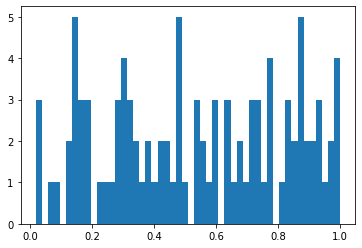

In [13]:
plt.hist(p_values, bins=50);

In [14]:
cluster = LocalCluster(
#     n_workers=multiprocessing.cpu_count(), 
    n_workers=12, 
    threads_per_worker=1, 
    processes=True, 
    silence_logs=logging.ERROR
)
client = Client(cluster)
client

# client = Client('tcp://127.0.0.1:55222')
# client

# client.restart()
# client.shutdown()

# client.close()

Client Scheduler: tcp://127.0.0.1:55417 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 12 Cores: 12 Memory: 34.36 GB


In [15]:
delayed_results = []
for x in range(0, 100):
    delayed_result = dask.delayed(run_experiments)(100)
    delayed_results.append(delayed_result)

output_base = dask.compute(*delayed_results)
output = list(itertools.chain.from_iterable(output_base))

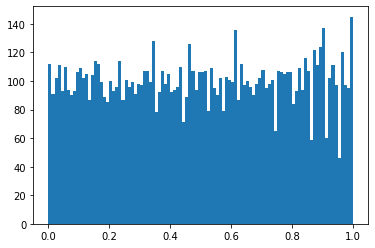

In [17]:
plt.hist(output, bins=100);

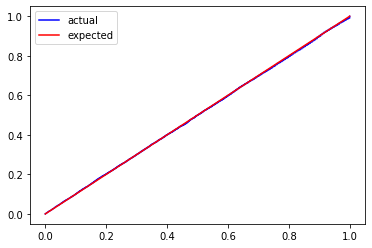

In [27]:
# CDF
x, y = sorted(output), np.arange(len(output)) / len(output)
plt.plot(x, y, color='b', label='actual');
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), color='r', label='expected');
plt.legend();

In [ ]:
# for cookie in [
#     '59a2a9b4-72e6-47a7-8ad7-e9354e359c5d',
#     '3992bf45-4bf0-4b22-960b-68dff65aeb11',
#     'aacaaa07-8817-4923-91ba-cb2493fd67e8',
#     'c74bb766-2f21-406f-ab53-cca07bcdd40e',
#     '47348fa6-0b12-4404-9480-b6ba6675f926',
#     '3b8ed263-344c-4d09-bedb-dc2ba9e1b63e',
#     'a1ccaca5-1154-44d0-9047-dd989dfa80ad',
#     '5e6e03ee-f714-48a1-bc2a-66f6d8357405',
#     '5e0c00d0-0944-4b66-8bbc-b167b595d836',
#     '9d195ea6-c6b1-4969-99a6-143b438511f6',
#     '612b906e-d779-422c-bb3a-d97552a5e7ec',
#     'f3c20856-fdf5-4560-87ea-df1eed049fae',
#     '57c7c387-0db6-4fc7-9a05-bc960b425e4b',
#     'c2561ad2-7531-4e26-8cdc-30a0ab350a07',
#     ]:
#     print (get_assignment(cookie))

# Validating Python Implementation against Ruby

In [62]:
experiment_identifier = "localization_redirect_experiment_ab"
user_token = "5b958f64-a5e3-4034-96ad-13e7d548e7e4"
int(hashlib.md5(f"{experiment_identifier}::{user_token}".encode('utf-8')).hexdigest(), 16)

244108449547940273546202436007003340559

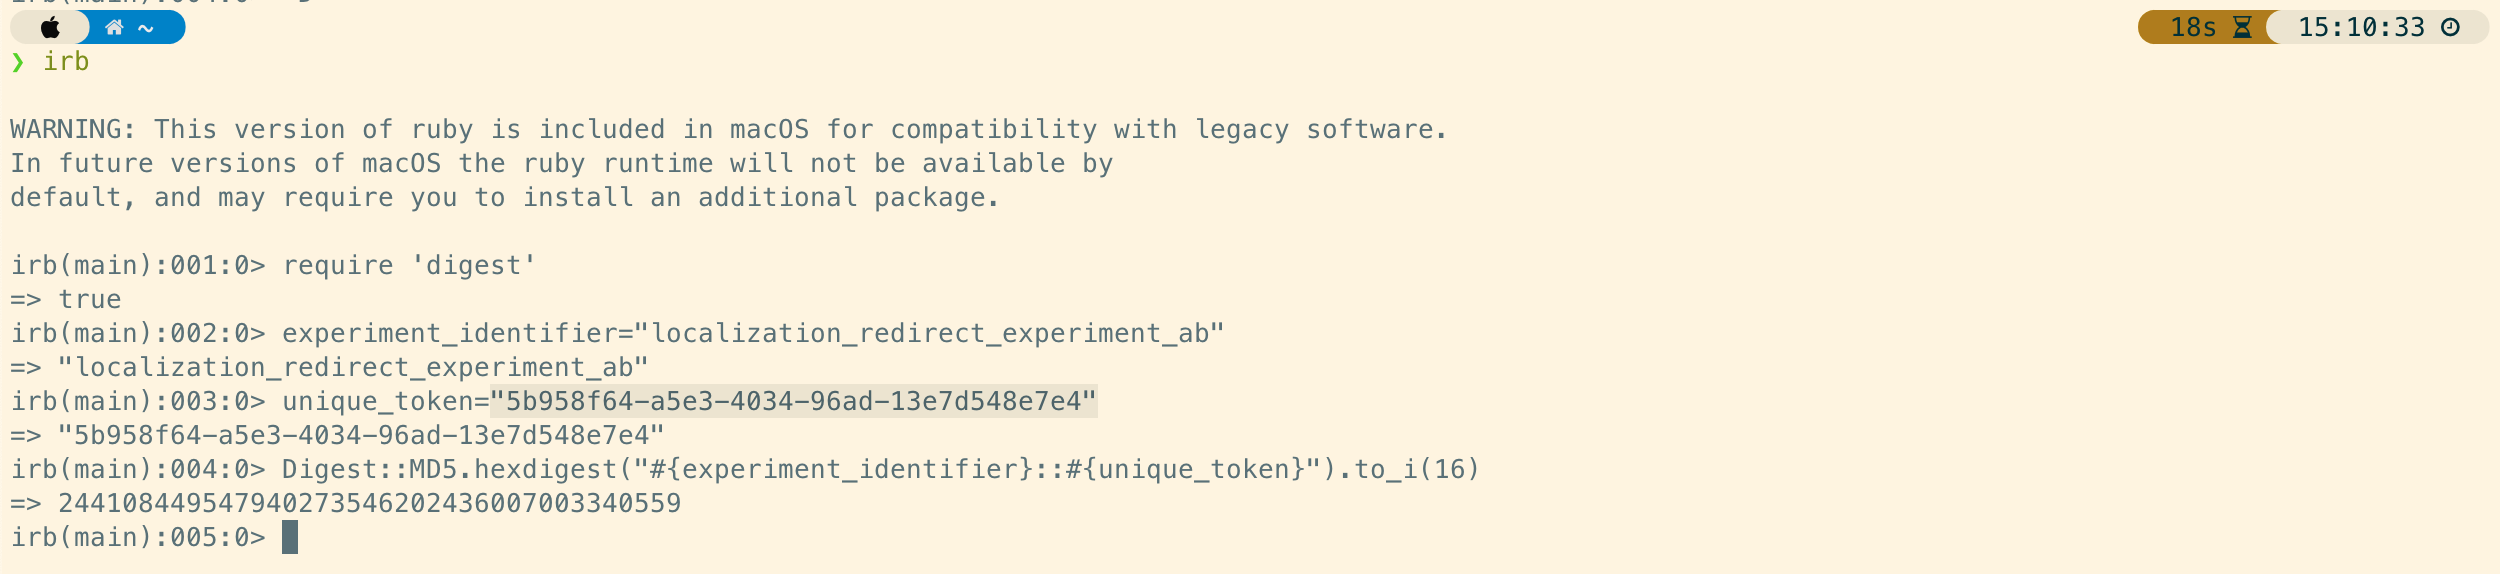

59